In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

In [2]:
num_workers = 4

batch_size = 128
default_learning_rate = 0.1

In [3]:
from torch import nn
import numpy as np
import torch
import vgg
import os
import sys
from tqdm import tqdm as tqdm
from util import get_number_of_parameters, get_accuracy, set_random_seeds
from IPython import display

In [4]:
module_path = os.path.dirname(os.getcwd())
sys.path.append(module_path)

home_path = module_path
figures_path = os.path.join(home_path, 'reports', 'figures')
models_path = os.path.join(home_path, 'reports', 'models')

In [5]:
device_id = 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=str(device_id)

device = torch.device("cuda:{}".format(device_id) if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device_id))

cuda:0
NVIDIA GeForce RTX 3090 Ti


In [6]:
from data import get_cifar_loader

In [7]:
train_loader = get_cifar_loader(batch_size=batch_size, train=True)
val_loader = get_cifar_loader(batch_size=batch_size, train=False)

Files already downloaded and verified
Files already downloaded and verified


tensor([[[-0.1529, -0.1608, -0.1608,  ..., -0.1451, -0.1373, -0.1373],
         [-0.1373, -0.1451, -0.1451,  ..., -0.0745, -0.1216, -0.1373],
         [-0.1451, -0.1529, -0.1529,  ..., -0.0118, -0.1059, -0.1451],
         ...,
         [-0.1529, -0.1608, -0.1529,  ..., -0.1059, -0.1294, -0.1529],
         [-0.1451, -0.1529, -0.1451,  ..., -0.1216, -0.1216, -0.1451],
         [-0.1529, -0.1608, -0.1608,  ..., -0.1451, -0.1373, -0.1451]],

        [[ 0.2000,  0.1922,  0.1922,  ...,  0.1922,  0.1765,  0.1843],
         [ 0.2157,  0.2078,  0.2078,  ...,  0.2000,  0.2000,  0.2157],
         [ 0.2078,  0.2000,  0.2000,  ...,  0.1608,  0.1843,  0.2157],
         ...,
         [ 0.2000,  0.1922,  0.2000,  ...,  0.1765,  0.2000,  0.2000],
         [ 0.2078,  0.2000,  0.2078,  ...,  0.1843,  0.2078,  0.2078],
         [ 0.2000,  0.1922,  0.1922,  ...,  0.1843,  0.1922,  0.1922]],

        [[ 0.6471,  0.6314,  0.6314,  ...,  0.6235,  0.6863,  0.6549],
         [ 0.6706,  0.6549,  0.6549,  ...,  0

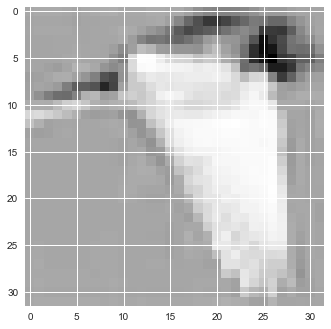

In [8]:
for X,y in train_loader:
    print(X[0])
    print(y[0])
    print(X[0].shape)
    label = X
    target = y
    plt.imshow(np.array(X[0,0,:,:]))
    print(X[0].max())
    print(X[0].min())
    break

In [9]:
model = vgg.VGG_A()
get_number_of_parameters(model)

9750922

In [10]:
model = vgg.VGG_A_Batch()
get_number_of_parameters(model)

9758474

In [11]:
model = vgg.VGG_A_Layer(label[0].shape)
get_number_of_parameters(model)

10056074

In [12]:
def train(model,
          optimizer,
          criterion,
          train_loader,
          val_loader,
          scheduler=None,
          epochs_n=100,
          best_model_path=None):

    model.to(device)
    learning_curve = [np.nan] * epochs_n
    train_accuracy_curve = [np.nan] * epochs_n
    val_accuracy_curve = [np.nan] * epochs_n
    max_val_accuracy = 0
    max_val_accuracy_epoch = 0

    batches_n = len(train_loader)

    for epoch in tqdm(range(epochs_n), unit='epoch'):
        if scheduler is not None:
            scheduler.step()
        model.train()

        learning_curve[epoch] = 0
        for data in train_loader:
            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)
            learning_curve[epoch] += loss.item()
            loss.backward()
            optimizer.step()

        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 3))

        learning_curve[epoch] /= batches_n
        axes[0].plot(learning_curve)

        model.eval()
        train_accuracy_curve[epoch] = get_accuracy(model, train_loader, device)
        val_accuracy_curve[epoch] = get_accuracy(model, val_loader, device)

        val_accuracy = val_accuracy_curve[epoch]
        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            max_val_accuracy_epoch = epoch
            if best_model_path:
                torch.save(model.state_dict(), best_model_path)

        axes[1].set_title('Train {:.4f}, val {:.4f}, max val {:.4f} at {}'.format(
            train_accuracy_curve[epoch], val_accuracy, max_val_accuracy, max_val_accuracy_epoch))
        axes[1].plot(train_accuracy_curve)
        axes[1].plot(val_accuracy_curve)

        plt.tight_layout()
        plt.show()

    return learning_curve, train_accuracy_curve, val_accuracy_curve

In [13]:
training_results = {}

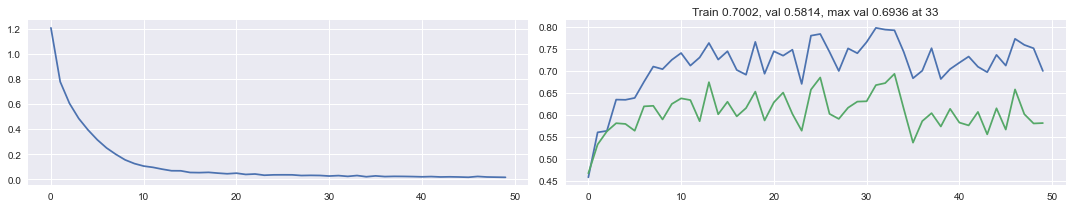

100%|██████████| 50/50 [2:20:47<00:00, 168.94s/epoch]


In [14]:
lr = 0.0005
model_name = 'vgg_bn_noisy'
experimment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experimment_name}.pt')  #change dump name here

set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A_Batch_Noisy()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results[experimment_name] = train(model,
                                           optimizer,
                                           criterion,
                                           train_loader,
                                           val_loader,
                                           epochs_n=50,
                                           best_model_path='VGG-Base-Comparison/' +
                                                           'VGG-LN_' + model_name + '_' +
                                                           experimment_name)

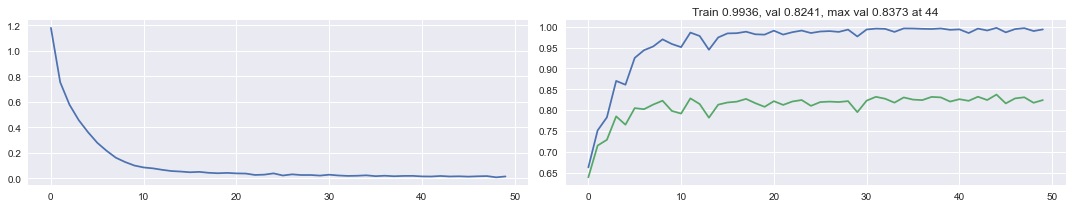

100%|██████████| 50/50 [24:27<00:00, 29.36s/epoch]


In [15]:
lr = 0.0005
model_name = 'vgg_bn'
experimment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experimment_name}.pt') #change dump name here

set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A_Batch()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results[experimment_name] = train(model,
                                           optimizer,
                                           criterion,
                                           train_loader,
                                           val_loader,
                                           epochs_n=50,
                                           best_model_path='VGG-Base-Comparison/'+
                                                           'VGG-BN_'+model_name+'_'+
                                                           experimment_name)

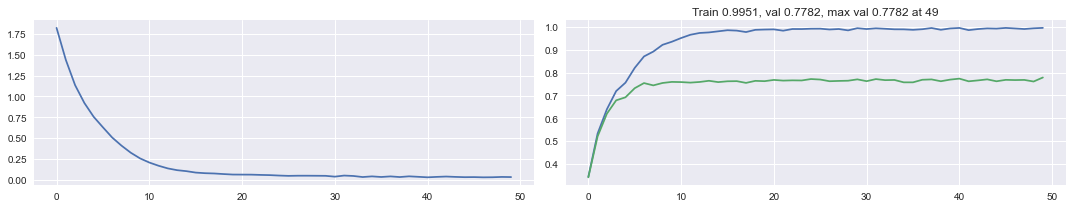

100%|██████████| 50/50 [22:45<00:00, 27.32s/epoch]


In [16]:
lr = 0.0005
model_name = 'vgg'
experimment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experimment_name}.pt') #change dump name here

set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results[experimment_name] = train(model,
                                           optimizer,
                                           criterion,
                                           train_loader,
                                           val_loader,
                                           epochs_n=50,
                                           best_model_path='VGG-Base-Comparison/'+
                                                           'VGG-Base_'+model_name+'_'+
                                                           experimment_name)

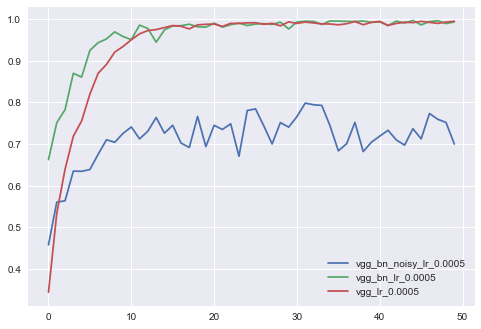

In [17]:
for key in training_results:
    curr_result = training_results[key]

    plt.plot(curr_result[1], label = key)
plt.legend()
plt.show()